In [1]:
import findspark    
findspark.init()

In [2]:
print(findspark.find())

C:\spark\spark-3.5.1-bin-hadoop3


In [1]:
from pyspark import SparkConf, SparkContext

# Create a SparkConf object to configure the application
conf = SparkConf().setAppName("TPCH BENCHMARK").setMaster("local[*]")

# Create a SparkContext object
sc = SparkContext(conf=conf)
sc

<SparkContext master=local[*] appName=TPCH BENCHMARK>

In [6]:
import findspark

# Initialize findspark
findspark.init()

from pyspark.sql import SparkSession

# Initialize the Spark session with increased memory settings
spark = SparkSession.builder \
    .appName("TPCHBenchmark") \
    .master("spark://172.21.48.1:7077") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()


# List of tables
tpch_tables = [
    'customer',
    'lineitem',
    'orders',
    'part',
    'supplier',
    'partsupp',
    'nation',
    'region'
]

# Read Parquet files into DataFrames
dataframes = {table: spark.read.parquet(f'./data/{table}.parquet') for table in tpch_tables}

# Register DataFrames as temporary views
for table, df in dataframes.items():
    df.createOrReplaceTempView(table)

# Example query
result = spark.sql("SELECT * FROM customer LIMIT 10")
result.show()

+---------+------------------+--------------------+-----------+---------------+---------+------------+--------------------+
|c_custkey|            c_name|           c_address|c_nationkey|        c_phone|c_acctbal|c_mktsegment|           c_comment|
+---------+------------------+--------------------+-----------+---------------+---------+------------+--------------------+
|        1|Customer#000000001|   j5JsirBM9PsCy0O1m|         15|25-989-741-2988|   711.56|    BUILDING|y final requests ...|
|        2|Customer#000000002|487LW1dovn6Q4dMVy...|         13|23-768-687-3665|   121.65|  AUTOMOBILE|y carefully regul...|
|        3|Customer#000000003|        fkRGN8nY4pkE|          1|11-719-748-3364|  7498.12|  AUTOMOBILE|fully. carefully ...|
|        4|Customer#000000004|         4u58h fqkyE|          4|14-128-190-5944|  2866.83|   MACHINERY| sublate. fluffil...|
|        5|Customer#000000005|hwBtxkoBF qSW4KrI...|          3|13-750-942-6364|   794.47|   HOUSEHOLD|equests haggle fu...|
|       

In [2]:
import time
import psutil
import pandas as pd
import matplotlib.pyplot as plt


In [7]:
queries = {
    "Query1": """
        SELECT
            l_returnflag,
            l_linestatus,
            SUM(l_quantity) AS sum_qty,
            SUM(l_extendedprice) AS sum_base_price,
            SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
            SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
            AVG(l_quantity) AS avg_qty,
            AVG(l_extendedprice) AS avg_price,
            AVG(l_discount) AS avg_disc,
            COUNT(*) AS count_order
        FROM
            lineitem
        WHERE
            l_shipdate <= DATE '1998-12-01' - INTERVAL 90 DAY
        GROUP BY
            l_returnflag,
            l_linestatus
        ORDER BY
            l_returnflag,
            l_linestatus
    """,
    "Query18": """
        SELECT
            c_name,
            c_custkey,
            o_orderkey,
            o_orderdate,
            o_totalprice,
            SUM(l_quantity)
        FROM
            customer,
            orders,
            lineitem
        WHERE
            o_orderkey IN (
                SELECT
                    l_orderkey
                FROM
                    lineitem
                GROUP BY
                    l_orderkey
                HAVING
                    SUM(l_quantity) > 300
            )
            AND c_custkey = o_custkey
            AND o_orderkey = l_orderkey
        GROUP BY
            c_name,
            c_custkey,
            o_orderkey,
            o_orderdate,
            o_totalprice
        ORDER BY
            o_totalprice DESC,
            o_orderdate
    """,
    "Query2": """
        SELECT
            s_acctbal,
            s_name,
            n_name,
            p_partkey,
            p_mfgr,
            s_address,
            s_phone,
            s_comment
        FROM
            part,
            supplier,
            partsupp,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND p_size = 15
            AND p_type LIKE '%BRASS'
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
            AND ps_supplycost = (
                SELECT
                    MIN(ps_supplycost)
                FROM
                    partsupp,
                    supplier,
                    nation,
                    region
                WHERE
                    p_partkey = ps_partkey
                    AND s_suppkey = ps_suppkey
                    AND s_nationkey = n_nationkey
                    AND n_regionkey = r_regionkey
                    AND r_name = 'EUROPE'
            )
        ORDER BY
            s_acctbal DESC,
            n_name,
            s_name,
            p_partkey
    """,
    "Query5": """
        SELECT
            n_name,
            SUM(l_extendedprice * (1 - l_discount)) AS revenue
        FROM
            customer,
            orders,
            lineitem,
            supplier,
            nation,
            region
        WHERE
            c_custkey = o_custkey
            AND l_orderkey = o_orderkey
            AND l_suppkey = s_suppkey
            AND c_nationkey = s_nationkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'ASIA'
            AND o_orderdate >= DATE '1994-01-01'
            AND o_orderdate < DATE '1995-01-01'
        GROUP BY
            n_name
        ORDER BY
            revenue DESC
    """,
    "Query9": """
        SELECT
            nation,
            o_year,
            SUM(amount) AS sum_profit
        FROM (
            SELECT
                n_name AS nation,
                YEAR(o_orderdate) AS o_year,
                l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
            FROM
                part,
                supplier,
                lineitem,
                partsupp,
                orders,
                nation
            WHERE
                s_suppkey = l_suppkey
                AND ps_suppkey = l_suppkey
                AND ps_partkey = l_partkey
                AND p_partkey = l_partkey
                AND o_orderkey = l_orderkey
                AND s_nationkey = n_nationkey
                AND p_name LIKE '%green%'
        ) AS profit
        GROUP BY
            nation,
            o_year
        ORDER BY
            nation,
            o_year DESC
    """
}


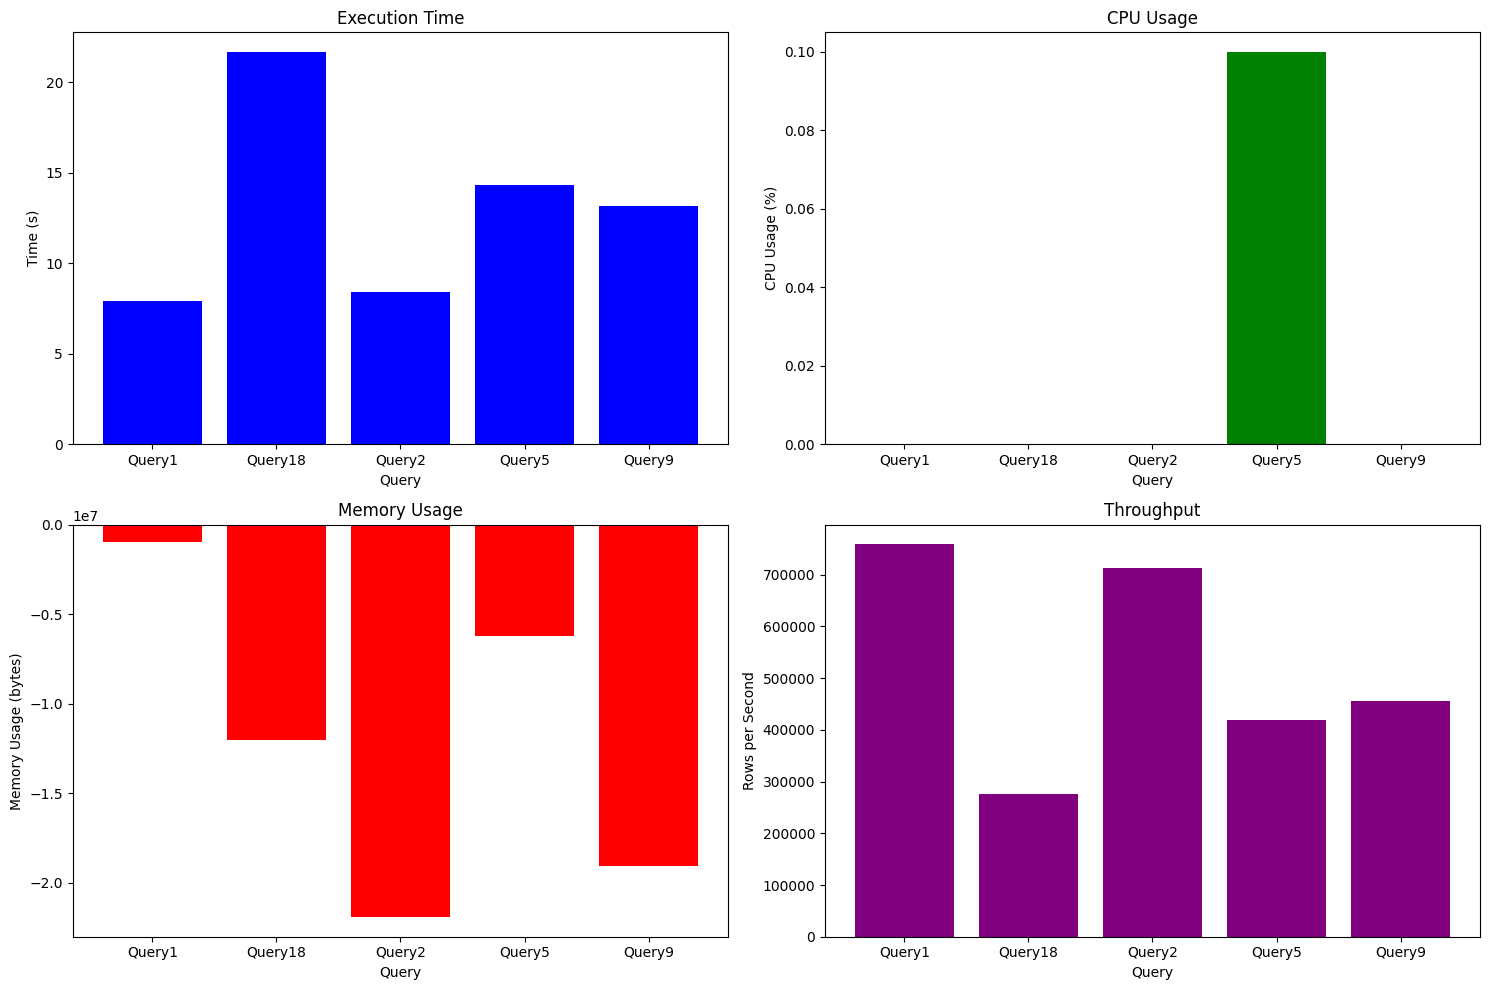

In [8]:
# Function to measure metrics
def measure_query_performance(spark, query):
    # Start measuring time
    start_time = time.time()
    
    # Start measuring CPU and Memory usage
    process = psutil.Process()
    start_cpu = process.cpu_percent(interval=None)
    start_mem = process.memory_info().rss
    
    # Execute the query
    spark.sql(query).collect()
    
    # End measuring CPU and Memory usage
    end_cpu = process.cpu_percent(interval=None)
    end_mem = process.memory_info().rss
    
    # End measuring time
    end_time = time.time()
    
    # Calculate metrics
    execution_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu
    memory_usage = end_mem - start_mem
    throughput = len(spark.sql("SELECT * FROM lineitem").collect()) / execution_time  # Number of rows per second
    
    return execution_time, cpu_usage, memory_usage, throughput

# Measure performance for each query
results = []
for query_name, query in queries.items():
    exec_time, cpu_usage, mem_usage, throughput = measure_query_performance(spark, query)
    results.append({
        "Query": query_name,
        "Execution Time": exec_time,
        "CPU Usage": cpu_usage,
        "Memory Usage": mem_usage,
        "Throughput": throughput
    })

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Execution Time
axs[0, 0].bar(df["Query"], df["Execution Time"], color='blue')
axs[0, 0].set_title("Execution Time")
axs[0, 0].set_xlabel("Query")
axs[0, 0].set_ylabel("Time (s)")

# CPU Usage
axs[0, 1].bar(df["Query"], df["CPU Usage"], color='green')
axs[0, 1].set_title("CPU Usage")
axs[0, 1].set_xlabel("Query")
axs[0, 1].set_ylabel("CPU Usage (%)")

# Memory Usage
axs[1, 0].bar(df["Query"], df["Memory Usage"], color='red')
axs[1, 0].set_title("Memory Usage")
axs[1, 0].set_xlabel("Query")
axs[1, 0].set_ylabel("Memory Usage (bytes)")

# Throughput
axs[1, 1].bar(df["Query"], df["Throughput"], color='purple')
axs[1, 1].set_title("Throughput")
axs[1, 1].set_xlabel("Query")
axs[1, 1].set_ylabel("Rows per Second")

plt.tight_layout()
plt.show()

In [9]:
df

,Query,Execution Time,CPU Usage,Memory Usage,Throughput
0,Query1,7.910183,0.0,-950272,758669.511690
1,Query18,21.677918,0.0,-12001280,276835.389811
2,Query2,8.419024,0.0,-21921792,712815.979231
3,Query5,14.311074,0.1,-6184960,419340.637346
4,Query9,13.184780,0.0,-19050496,455162.328232


### DON'T RUN THESE CODE BELOW YET

In [20]:
from pyspark.sql import SparkSession


# Initialize the Spark session with increased memory settings
spark = SparkSession.builder \
    .appName("TPCHBenchmark 2") \
    .master("spark://172.21.48.1:7077") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

In [21]:
# Customer table schema
schema_customer = """
c_custkey INT,
c_name STRING,
c_address STRING,
c_nationkey INT,
c_phone STRING,
c_acctbal DOUBLE,
c_mktsegment STRING,
c_comment STRING
"""

# Orders table schema
schema_orders = """
o_orderkey INT,
o_custkey INT,
o_orderstatus STRING,
o_totalprice DOUBLE,
o_orderdate DATE,
o_orderpriority STRING,
o_clerk STRING,
o_shippriority INT,
o_comment STRING
"""

# Lineitem table schema
schema_lineitem = """
l_orderkey INT,
l_partkey INT,
l_suppkey INT,
l_linenumber INT,
l_quantity DOUBLE,
l_extendedprice DOUBLE,
l_discount DOUBLE,
l_tax DOUBLE,
l_returnflag STRING,
l_linestatus STRING,
l_shipdate DATE,
l_commitdate DATE,
l_receiptdate DATE,
l_shipinstruct STRING,
l_shipmode STRING,
l_comment STRING
"""

# Nation table schema
schema_nation = """
n_nationkey INT,
n_name STRING,
n_regionkey INT,
n_comment STRING
"""

# Part table schema
schema_part = """
p_partkey INT,
p_name STRING,
p_mfgr STRING,
p_brand STRING,
p_type STRING,
p_size INT,
p_container STRING,
p_retailprice DOUBLE,
p_comment STRING
"""

# Partsupp table schema
schema_partsupp = """
ps_partkey INT,
ps_suppkey INT,
ps_availqty INT,
ps_supplycost DOUBLE,
ps_comment STRING
"""

# Region table schema
schema_region = """
r_regionkey INT,
r_name STRING,
r_comment STRING
"""

# Supplier table schema
schema_supplier = """
s_suppkey INT,
s_name STRING,
s_address STRING,
s_nationkey INT,
s_phone STRING,
s_acctbal DOUBLE,
s_comment STRING
"""


In [22]:
# Example to read a CSV file with a given schema
df_customer = spark.read.csv("data/customer.csv", sep='|', schema=schema_customer)
df_orders = spark.read.csv("data/orders.csv", sep='|', schema=schema_orders)
df_lineitem = spark.read.csv("data/lineitem.csv", sep='|', schema=schema_lineitem)
df_nation = spark.read.csv("data/nation.csv", sep='|', schema=schema_nation)
df_part = spark.read.csv("data/part.csv", sep='|', schema=schema_part)
df_partsupp = spark.read.csv("data/partsupp.csv", sep='|', schema=schema_partsupp)
df_region = spark.read.csv("data/region.csv", sep='|', schema=schema_region)
df_supplier = spark.read.csv("data/supplier.csv", sep='|', schema=schema_supplier)


In [23]:
df_region

DataFrame[r_regionkey: int, r_name: string, r_comment: string]

In [24]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, DateType
import time
import psutil


# Define schema for lineitem
schema_lineitem = StructType([
    StructField("l_orderkey", IntegerType(), True),
    StructField("l_partkey", IntegerType(), True),
    StructField("l_suppkey", IntegerType(), True),
    StructField("l_linenumber", IntegerType(), True),
    StructField("l_quantity", DoubleType(), True),
    StructField("l_extendedprice", DoubleType(), True),
    StructField("l_discount", DoubleType(), True),
    StructField("l_tax", DoubleType(), True),
    StructField("l_returnflag", StringType(), True),
    StructField("l_linestatus", StringType(), True),
    StructField("l_shipdate", DateType(), True),
    StructField("l_commitdate", DateType(), True),
    StructField("l_receiptdate", DateType(), True),
    StructField("l_shipinstruct", StringType(), True),
    StructField("l_shipmode", StringType(), True),
    StructField("l_comment", StringType(), True)
])

# Load data
df_lineitem = spark.read.csv("data/lineitem.csv", sep='|', schema=schema_lineitem)
df_lineitem.createOrReplaceTempView("lineitem")

In [19]:
import os
import psutil

# Define query
query = """
SELECT
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= DATE '1998-12-01' - INTERVAL 90 DAYS
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus
"""

# Function to measure CPU and memory usage
def measure_performance():
    process = psutil.Process(os.getpid())
    cpu_times = process.cpu_times()
    memory_info = process.memory_info()
    return {
        'cpu_user_time': cpu_times.user,
        'cpu_system_time': cpu_times.system,
        'memory_rss': memory_info.rss,
        'memory_vms': memory_info.vms
    }

# Start measuring performance
start_time = time.time()
start_perf = measure_performance()

# Execute query
result = spark.sql(query)
result.show()

# End measuring performance
end_perf = measure_performance()
end_time = time.time()

# Calculate metrics
execution_time = end_time - start_time
cpu_user_time = end_perf['cpu_user_time'] - start_perf['cpu_user_time']
cpu_system_time = end_perf['cpu_system_time'] - start_perf['cpu_system_time']
memory_usage = end_perf['memory_rss'] - start_perf['memory_rss']

print(f"Execution time: {execution_time} seconds")
print(f"CPU user time: {cpu_user_time} seconds")
print(f"CPU system time: {cpu_system_time} seconds")
print(f"Memory usage: {memory_usage} bytes")


+------------+------------+-------+--------------+--------------+----------+-------+---------+--------+-----------+
|l_returnflag|l_linestatus|sum_qty|sum_base_price|sum_disc_price|sum_charge|avg_qty|avg_price|avg_disc|count_order|
+------------+------------+-------+--------------+--------------+----------+-------+---------+--------+-----------+
+------------+------------+-------+--------------+--------------+----------+-------+---------+--------+-----------+

Execution time: 8.118799924850464 seconds
CPU user time: 0.0 seconds
CPU system time: 0.0 seconds
Memory usage: 200704 bytes
